In [ ]:
import os
import toml
import pandas as pd

In [3]:
TYPE = "lung"
CONFIG_PATH = f"../config/{TYPE}.toml"
config = toml.load(CONFIG_PATH)

In [4]:
def inspect_nan(df, name):
    print(df[pd.isna(df[name])])

In [5]:
import toml

def update_nested_toml(section_path, key, value):
    try:
        with open(CONFIG_PATH, 'r') as f:
            config = toml.load(f)
        sections = section_path.split('.')
        current = config
        for section in sections:
            current = current.setdefault(section, {})
        
        current[key] = value
        
        with open(CONFIG_PATH, 'w') as f:
            toml.dump(config, f)
    except Exception as e:
        print(f"An error occurred: {e}")

In [6]:
beta_file_number = config["init"]["hyper"]["beta_file_number"]
test_ratio = config["init"]["hyper"]["test_ratio"]
seed = config["init"]["hyper"]["splitting_seed"]
normal_number_0 = config["init"]["hyper"]["normal_number_0"]
normal_number_1 = config["init"]["hyper"]["normal_number_1"]
cancer_type = config["init"]["hyper"]["cancer_type"]
data_source = config["init"]["hyper"]["data_source"]
is_columns_duplicated = config["init"]["hyper"]["is_columns_duplicated"]

In [7]:
trainOutPath = f"../{cancer_type}/result/{data_source}/train{int(100-test_ratio*100)}"
testOutPath = f"../{cancer_type}/result/{data_source}/test{int(test_ratio*100)}"

### Section. 0 Merge and Split Champ Data 
(if there are more than one normalized beta data)

#### Summary
- beta data is split into train and test
- all beta data will the following format
  - column 0 is the id of the sample
  - column 1 to n is the beta value of each CpG site
  - normal samples come first, then tumor samples

In [10]:
df0 = pd.read_csv(f"../{cancer_type}/champ_result/{data_source}/all_beta_normalized_0.csv")

In [11]:
if beta_file_number == 2:
    df1 = pd.read_csv(f"../{cancer_type}/champ_result/{data_source}/all_beta_normalized_1.csv")

In [12]:
# potential feature loss
if beta_file_number == 2:
    feature_name0 = df0.iloc[:, 0].tolist()
    feature_name1 = df1.iloc[:, 0].tolist()

    feature_name = list(set(feature_name0).intersection(feature_name1))
    update_nested_toml("preprocess.merge_and_split", "feature_size_0", len(feature_name0))
    update_nested_toml("preprocess.merge_and_split", "feature_size_1", len(feature_name1))
    update_nested_toml("preprocess.merge_and_split", "feature_size_intersection", len(feature_name))


In [13]:
if beta_file_number == 2:
    df0t = df0[df0.iloc[:, 0].isin(feature_name)]
    df1t = df1[df1.iloc[:, 0].isin(feature_name)]

In [14]:
if beta_file_number == 2:
    df0t = df0t.iloc[:, 1::is_columns_duplicated]
    df1t = df1t.iloc[:, 1::is_columns_duplicated]
    df0t.reset_index(drop=True, inplace=True)
    df1t.reset_index(drop=True, inplace=True)
    df0n = df0t.iloc[:, :normal_number_0]
    df0c = df0t.iloc[:, normal_number_0:]
    df1n = df1t.iloc[:, :normal_number_1]
    df1c = df1t.iloc[:, normal_number_1:]

In [15]:
if beta_file_number == 2:    
    dfn = pd.concat([df0n, df1n], axis = 1)
    dfc = pd.concat([df0c, df1c], axis = 1)

In [16]:
# drop those samples with missing value
# note: could use padding or other methods to fill the missing value

update_nested_toml("preprocess.merge_and_split", "Before_dropna_dfn_shape", dfn.shape)
update_nested_toml("preprocess.merge_and_split", "Before_dropna_dfc_shape", dfc.shape)
if beta_file_number == 2:
    dfn.dropna(inplace = True, axis = 1)
    dfc.dropna(inplace = True, axis = 1)
    update_nested_toml("preprocess.merge_and_split", "After_dropna_dfn_shape", dfn.shape)
    update_nested_toml("preprocess.merge_and_split", "After_dropna_dfc_shape", dfc.shape)

In [17]:
if beta_file_number == 2:
    df = pd.concat([dfn, dfc], axis = 1)
    df.columns = range(df.shape[1])

In [18]:
X = df.T
y = [(0 if i < dfn.shape[1] else 1) for i in range((df.shape[1]))]

In [ ]:
from collections import Counter
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_ratio, random_state=seed
)

train_class_distribution = Counter(y_train)
testing_class_distribution = Counter(y_test)

update_nested_toml("preprocess.merge_and_split", "training_set_samples", len(X_train))
update_nested_toml("preprocess.merge_and_split", "testing_set_samples", len(X_test))
update_nested_toml("preprocess.merge_and_split", "train_class_distribution", [train_class_distribution[0], train_class_distribution[1]])
update_nested_toml("preprocess.merge_and_split", "testing_class_distribution", [testing_class_distribution[0], testing_class_distribution[1]])

In [20]:
X_train.columns = feature_name
X_train["label"] = y_train
X_train = X_train.sort_values(by=["label"])
train_df = X_train.T
train_df.columns = range(train_df.shape[1])

X_test.columns = feature_name
X_test["label"] = y_test
X_test = X_test.sort_values(by=["label"])
test_df = X_test.T
test_df.columns = range(test_df.shape[1])
train_df.insert(0, 'Unnamed: 0', train_df.index)
train_df.reset_index(drop=True, inplace=True)

In [21]:
os.makedirs(
    f"{trainOutPath}", exist_ok=True
)
os.makedirs(
    f"{testOutPath}",
    exist_ok=True,
)

train_df.to_csv(f"{trainOutPath}/all_beta_normalized_0.csv", index=False)
test_df.to_csv(f"{testOutPath}/all_beta_normalized_1.csv", index=False)

In [ ]:
del df0, df1, df0t, df1t, df0n, df0c, df1n, df1c, dfn, dfc, df, X, y, X_train, X_test, y_train, y_test, test_df

### Sec. 1 dbeta calculation
#### Summary
- calculate the difference of beta value between tumor and normal samples
- the output file will have the following format
  - column 0 is the id of the sample
  - column 1 is the gene name
  - column 2 is the difference of beta value between tumor and normal samples

### Implementation
1. split normal and tumor samples
2. remove outliers in normal and tumor samples
3. calculate the mean of normal sammples
4. tumor - avg(normal)
5. calculate the mean of tumor samples
6. merge with DMP file
7. exclude the genes not in single comorbidity list

In [8]:
train_df = pd.read_csv(f"{trainOutPath}/all_beta_normalized_0.csv")

In [9]:
def IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    upper_fence = Q3 + IQR * 1.5
    lower_fence = Q1 - IQR * 1.5
    return upper_fence, lower_fence


def no_outlier(df):
    upper_fence, lower_fence = IQR(df)
    ddf = df[(df > lower_fence) & (df < upper_fence)]
    return ddf

In [10]:
config = toml.load(CONFIG_PATH)
normal_count = config["preprocess"]["merge_and_split"]["train_class_distribution"][0]
all_beta_normalized_normal = train_df.iloc[
    :-1, 1 : normal_count + 1 :
]


all_beta_normalized_tumor = train_df.iloc[
    :-1, normal_count + 1::
]

In [11]:
all_beta_normalized_normal = no_outlier(all_beta_normalized_normal)
all_beta_normalized_tumor = no_outlier(all_beta_normalized_tumor)

In [12]:
train_normal_avg = all_beta_normalized_normal.mean(skipna=True, axis=1)

In [13]:
all_beta_normalized_tumor = (all_beta_normalized_tumor).subtract(
    train_normal_avg, axis=0
)

In [14]:
all_beta_normalized_tumor = no_outlier(all_beta_normalized_tumor)

In [15]:
train_tumor_mean = all_beta_normalized_tumor.mean(skipna=True, axis=1)

In [16]:
delta_beta = pd.merge(
    train_df.iloc[:-1, :1],
    pd.DataFrame(train_tumor_mean, columns=["dbeta"]),
    left_index=True,
    right_index=True,
)
update_nested_toml("preprocess.dbeta", "delta_beta_avg", delta_beta.shape[0])

In [17]:
# print(delta_beta[pd.isna(delta_beta["dbeta"])])
# record the list of feature with dbeta being NaN
update_nested_toml("preprocess.dbeta", "NaN_dbeta_feature", delta_beta.loc[pd.isna(delta_beta["dbeta"]), "Unnamed: 0"].tolist())
delta_beta.dropna(inplace=True, axis=0)
update_nested_toml("preprocess.dbeta", "delta_beta_avg_remove_NaN", delta_beta.shape[0])

In [18]:
dmp = pd.read_csv(f"../{cancer_type}/champ_result/{data_source}/DMP_result_0.csv")
dmp = dmp[["Unnamed: 0", "gene", "feature"]]
update_nested_toml("preprocess.dbeta", "dmp_before_dropna_shape_feature", dmp.shape[0])
dmp.dropna(inplace=True)
update_nested_toml("preprocess.dbeta", "dmp_after_dropna_shape_feature", dmp.shape[0])


In [19]:
result = pd.merge(delta_beta, dmp, on="Unnamed: 0", how="left")
update_nested_toml("preprocess.dbeta", "delta_beta_avg_remove_NaN_with_gene_name", result.shape[0])

In [20]:
def find_max_dBeta_grouped(group):
    idx_max = group["dbeta"].abs().idxmax()
    return group.loc[idx_max]


dbeta = result.groupby("gene", as_index=False).apply(
    find_max_dBeta_grouped, include_groups=False
)

In [21]:
dbeta.columns = ["gene", "ID", "dbeta", "feature"]
dbeta = dbeta[["ID", "gene", "dbeta", "feature"]]
# DEBUG
dbeta
# END

,ID,gene,dbeta,feature
0,cg03630821,A1BG,0.026261,Body
1,cg07849944,A2BP1,0.032438,5'UTR
2,cg14888445,A2LD1,-0.024310,Body
3,cg08300930,A2M,0.004000,Body
4,cg15384867,A2ML1,0.015780,Body
...,...,...,...,...
14414,cg00397635,ZYG11A,0.022089,Body
14415,cg24675658,ZYG11B,0.011249,TSS200
14416,cg05102190,ZYX,0.008661,TSS200
14417,cg02574861,ZZEF1,-0.024118,Body


In [38]:
# comorbidity = pd.read_csv(
#     "../external_result/matchgene174_single_3Y10__OR2.txt", sep="\t", header=None
# )
# dbeta = dbeta[
#     dbeta["gene"].isin(comorbidity[0])
# ]


# result_max_per_gene_single

In [22]:
dbeta.to_csv(f"{trainOutPath}/dbeta.csv", index=False)

### Sec. 2 Filter genes by dbeta values
1. filter genes by dbeta values
3. filter genes by TSS position
4. plot distribution of dbeta values
5. plot PCA for normal and tumor


In [40]:
# dbeta = pd.read_csv(f"{trainOutPath}/dbeta.csv")

In [23]:
TSS = dbeta[dbeta["feature"].str.contains("TSS")]
TSS.to_csv(f"{trainOutPath}/dbeta_TSS.csv", index=False)
# DEBUG
TSS
# END

,ID,gene,dbeta,feature
10,cg09518518,AADACL4,-0.034798,TSS1500
11,cg14239811,AADAT,-0.030695,TSS1500
12,cg21174435,AAK1,0.017538,TSS1500
13,cg04424379,AARS,-0.019371,TSS200
14,cg19291355,AARS2,-0.017343,TSS200
...,...,...,...,...
14411,cg20309358,ZWILCH,0.022570,TSS1500
14412,cg06313381,ZWINT,0.008943,TSS200
14415,cg24675658,ZYG11B,0.011249,TSS200
14416,cg05102190,ZYX,0.008661,TSS200


In [24]:
threshold = 0.5
TSS_threshold = TSS[abs(TSS["dbeta"]) > threshold]
while True:
    TSS_threshold = TSS[abs(TSS["dbeta"]) > threshold]
    count = TSS_threshold.shape[0]
    if config["preprocess"]["filtering"]["hyper"]["avg_dbeta_lower_bound"] <= count <= config["preprocess"]["filtering"]["hyper"]["avg_dbeta_upper_bound"]:
        break
    threshold -= 0.01
threshold = round(threshold, 2)
update_nested_toml("preprocess.filtering", "threshold", threshold)

In [25]:
TSS_threshold.to_csv(f"{trainOutPath}/dbeta_TSS_{threshold}.csv", index=False)

Text(0.5, 1.0, 'Density plot of delta Beta value')

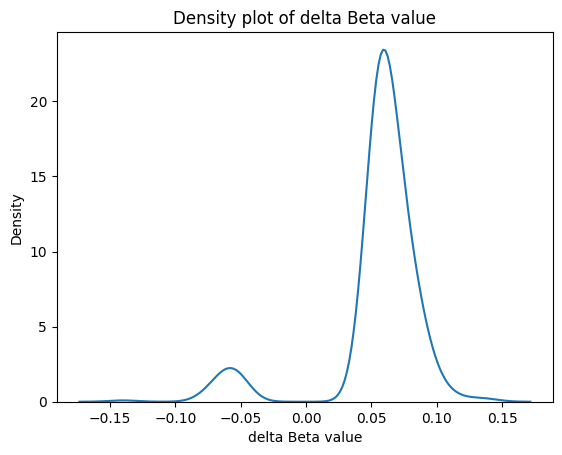

In [26]:
# DEBUG
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(TSS_threshold["dbeta"])
plt.xlabel("delta Beta value")
plt.title("Density plot of delta Beta value")
# END

In [27]:
normal_count = (train_df.iloc[-1, 1:] == 0).sum()
df_gene = train_df.iloc[:-1, :]
df_gene = df_gene[
    df_gene[df_gene.columns[0]].isin(dbeta["ID"])
]
X = df_gene.iloc[:, 1:].reset_index(drop=True).T
y = [0 if i < normal_count else 1 for i in range(X.shape[0])]
# DEBUG
print(f"X shape: {X.shape}")
print(f"y shape: {len(y)}")

X shape: (600, 14419)
y shape: 600


In [28]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

df = pd.DataFrame({
    'Principal Component 1': X_pca[:, 0],
    'Principal Component 2': X_pca[:, 1],
    'Principal Component 3': X_pca[:, 2],
    'Class': y
})

fig = px.scatter_3d(
    df,
    x='Principal Component 1',
    y='Principal Component 2',
    z='Principal Component 3',
    color='Class',
    title='PCA of Dataset',
    color_continuous_scale='Viridis'
)

fig.update_layout(
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    )
)

# fig.show()

fig.write_html(f"{trainOutPath}/preprocess_filtering_pca.html")
